In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -3,
                   'log_scale': -2.3,
                   'logit_rho': special.logit(.6),
                   'phi': -0.3,
                    'pi': -2.3, 
                   'theta': 0.15}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2_000
sim_dim = 500
innov_dim = 500

In [6]:
bounds = {'pi': {'max': 0, 'min':-35, 'dim':35}, 'phi': {'max': 0, 'min':-.5, 'dim':8}, 
          'theta': {'max':4, 'min': 0, 'dim':12}}

In [7]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [8]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.02034864625098453,
 'return_var': 0.017873157660876243,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [9]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [10]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.011964,0.021934
std,0.014681,0.104541
min,0.000010,-0.512085
25%,0.001939,-0.023522
50%,0.006711,0.022099
75%,0.016687,0.069182
max,0.115375,0.644502


In [11]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [12]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [13]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

## We start by examining the distributions of simulated data

In [14]:
data.corr()

,vol,rtn
vol,1.000000,-0.019311
rtn,-0.019311,1.000000


In [15]:
data.head()

,vol,rtn
2000-01-01,0.001836,0.039779
2000-01-02,0.000010,0.014915
2000-01-03,0.001774,-0.008452
2000-01-04,0.001149,0.015056
2000-01-05,0.000086,0.014427


In [16]:
data.var()

vol    0.000216
rtn    0.010929
dtype: float64

In [17]:
vl.compute_vol_gmm(data.vol)

({'log_both': -5.930037761549001,
  'log_scale': -5.506163240212154,
  'logit_rho': 1.2650207500703528},
            log_both  log_scale  logit_rho
 log_both   0.005392   0.001057  -0.006136
 log_scale  0.001057   0.001737  -0.000597
 logit_rho -0.006136  -0.000597   0.017205)

In [18]:
omega, omega_cov = vl.estimate_params(data)

In [19]:
total_est, total_cov = vl.estimate_params_strong_id(data, bounds=bounds)

In [20]:
omega

{'gamma': 0.013387603765924991,
 'beta': 3.9491764428157703,
 'psi': -3.229874444457632,
 'zeta': 0.828326903416641,
 'log_both': -5.930037761549001,
 'log_scale': -5.506163240212154,
 'logit_rho': 1.2650207500703528}

In [21]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.015401,-4.127376e-05,0.000000,0.000000,0.000000,-0.011929,0.000000
gamma,-0.000041,3.265380e-07,0.000000,0.000000,0.000000,0.000014,0.000000
log_both,0.000000,0.000000e+00,0.005392,0.001057,-0.006136,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.001057,0.001737,-0.000597,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.006136,-0.000597,0.017205,0.000000,0.000000
psi,-0.011929,1.392879e-05,0.000000,0.000000,0.000000,0.045420,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000691


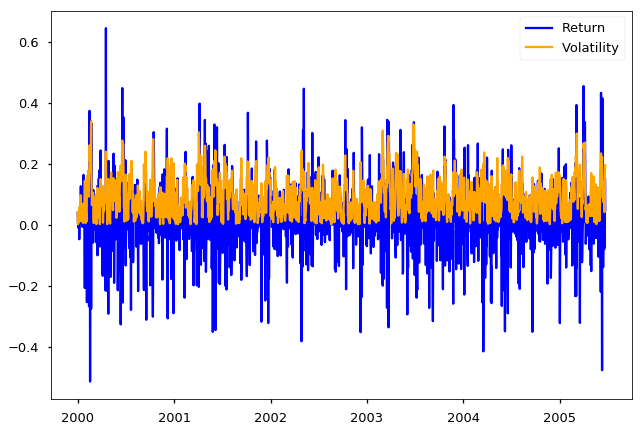

In [22]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [23]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.003589,-0.000160
rtn,-0.000160,0.010929


In [24]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

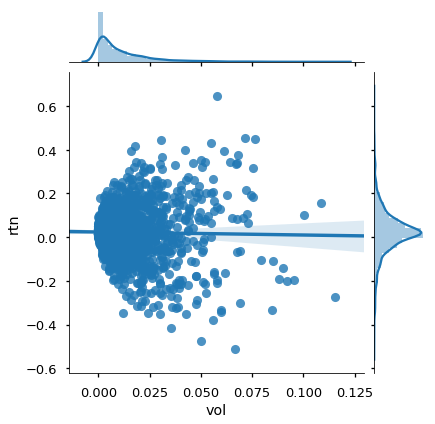

In [25]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [26]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.011964,0.021934
std,0.014681,0.104541
min,0.000010,-0.512085
25%,0.001939,-0.023522
50%,0.006711,0.022099
75%,0.016687,0.069182
max,0.115375,0.644502


## I now estimate all of the parameters

In [27]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [28]:
vl.compute_init_constants(data.vol)

{'log_both': -5.891969926715074,
 'log_scale': -5.489457118160047,
 'logit_rho': 1.210860598169388}

In [29]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [30]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -6.03605499678583,
  'log_scale': -5.522145949322916,
  'logit_rho': 1.455333136799839},
            log_both  log_scale  logit_rho
 log_both   0.009124   0.001284  -0.011520
 log_scale  0.001284   0.002029  -0.001070
 logit_rho -0.011520  -0.001070   0.027168)

In [31]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [32]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [33]:
estimator(data_arr[0])

({'gamma': 0.011329212264049869,
  'beta': 4.283672097798827,
  'psi': -3.6657366422269795,
  'zeta': 0.8380402900692674,
  'log_both': -6.03605499678583,
  'log_scale': -5.522145949322916,
  'logit_rho': 1.455333136799839,
  'phi': -0.4001233994335316,
  'pi': -14.997937965871929,
  'theta': 1.4739161562254197},
                beta         gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.013277 -3.670148e-05  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000037  2.716345e-07  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000e+00  0.009124   0.001284  -0.011520       NaN   
 log_scale  0.000000  0.000000e+00  0.001284   0.002029  -0.001070       NaN   
 logit_rho  0.000000  0.000000e+00 -0.011520  -0.001070   0.027168       NaN   
 phi             NaN           NaN       NaN        NaN        NaN  0.001032   
 pi              NaN           NaN       NaN        NaN        NaN -0.363029   
 psi       -0.010426  1.558372e-05  0.000000 

In [34]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [35]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [36]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [37]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta', 'psi']

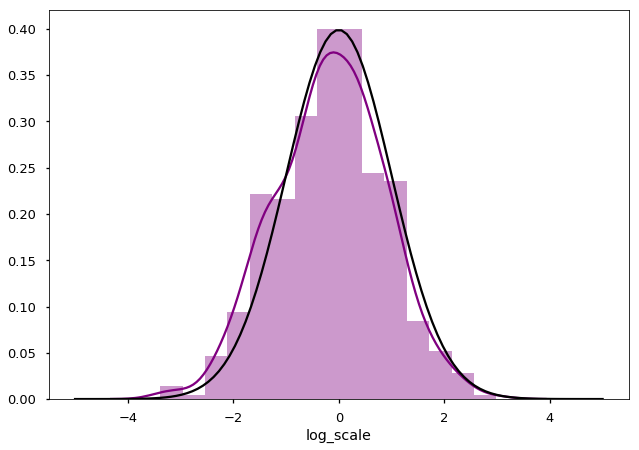

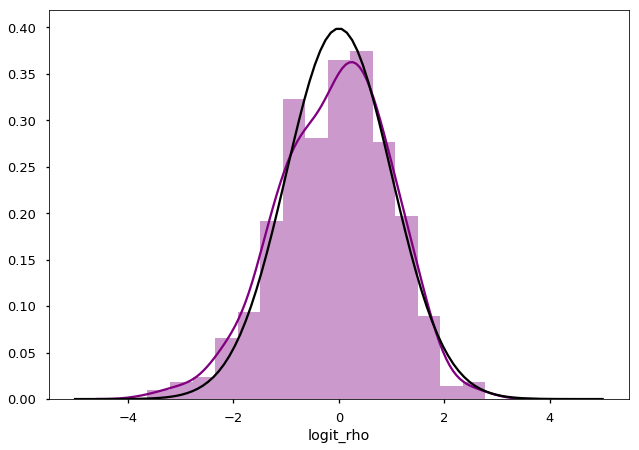

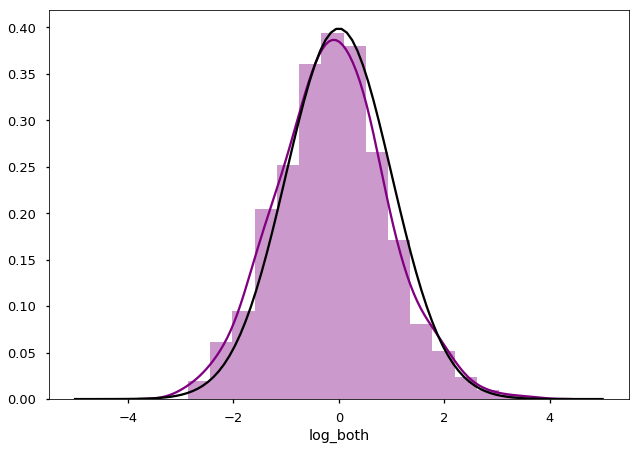

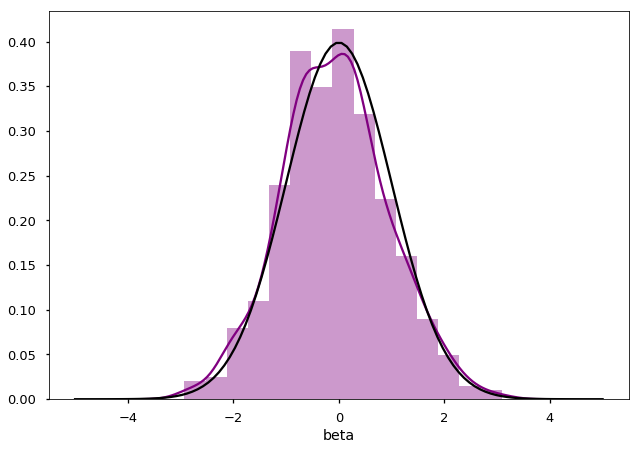

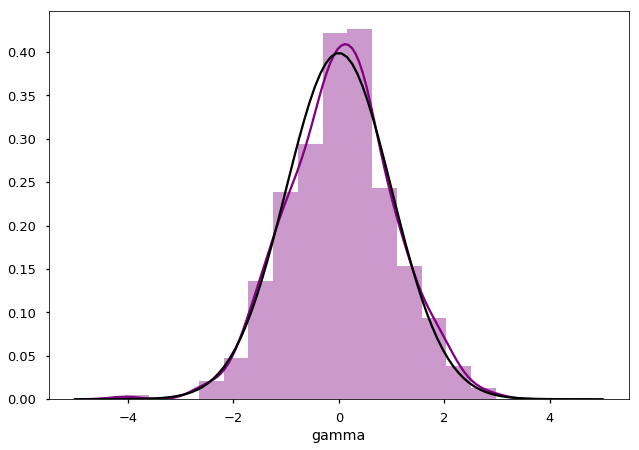

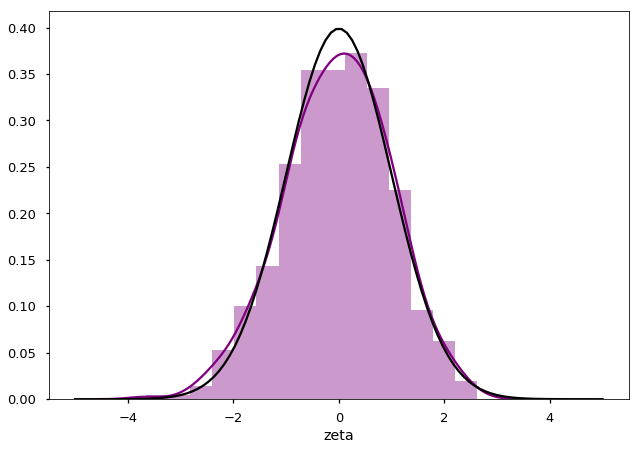

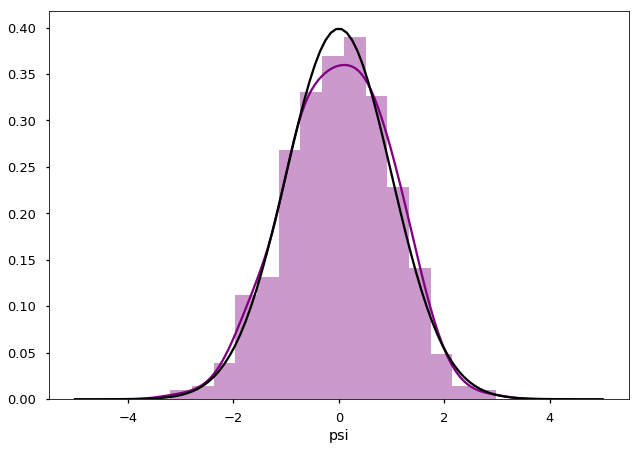

In [38]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [39]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [40]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

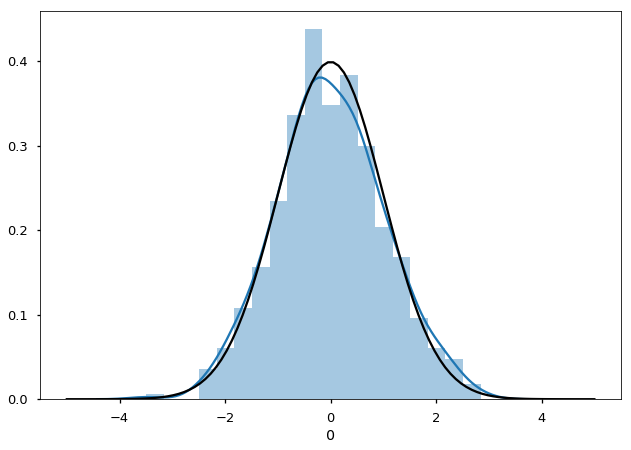

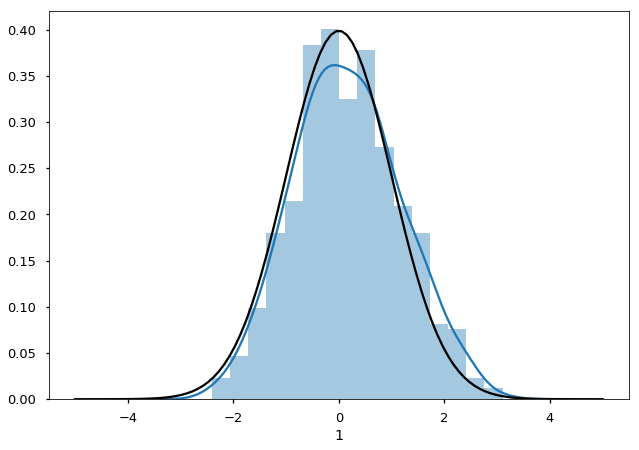

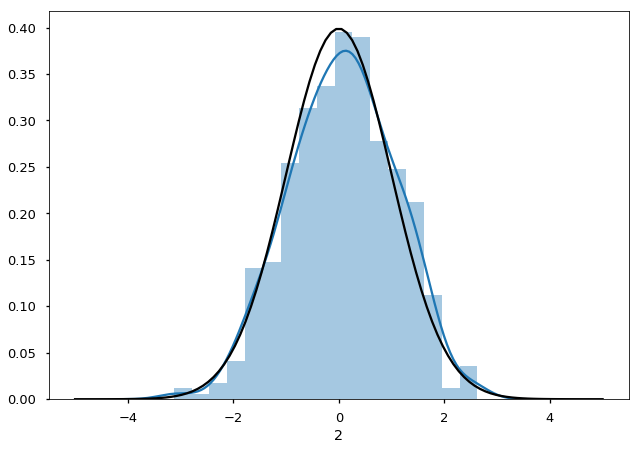

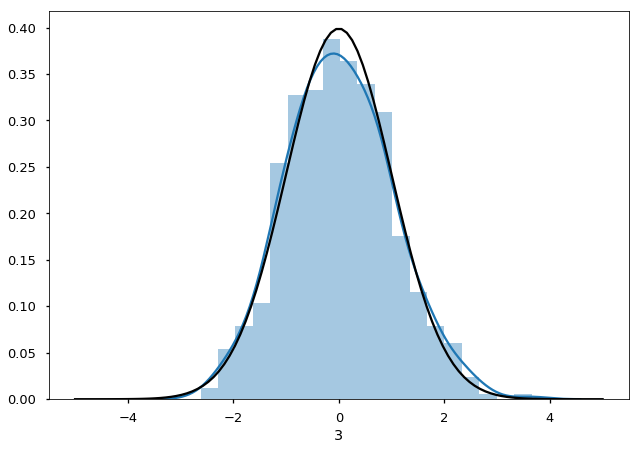

In [41]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

In [42]:
bounds

{'pi': {'max': 0, 'min': -35, 'dim': 35},
 'phi': {'max': 0, 'min': -0.5, 'dim': 8},
 'theta': {'max': 4, 'min': 0, 'dim': 12}}

In [43]:
true_params['pi']

-10

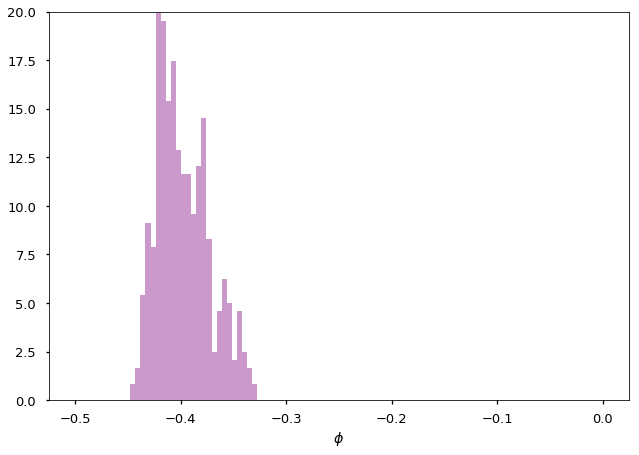

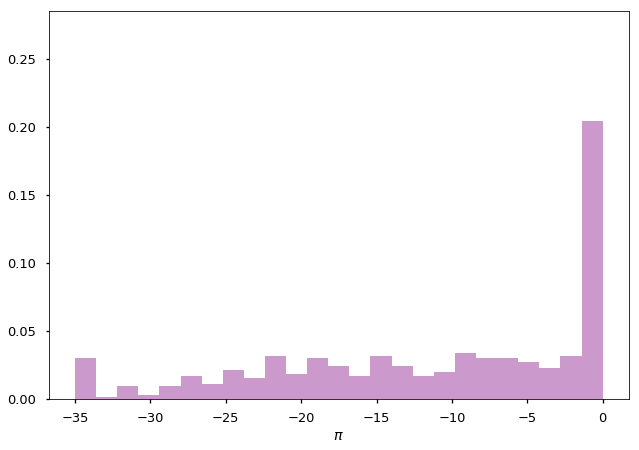

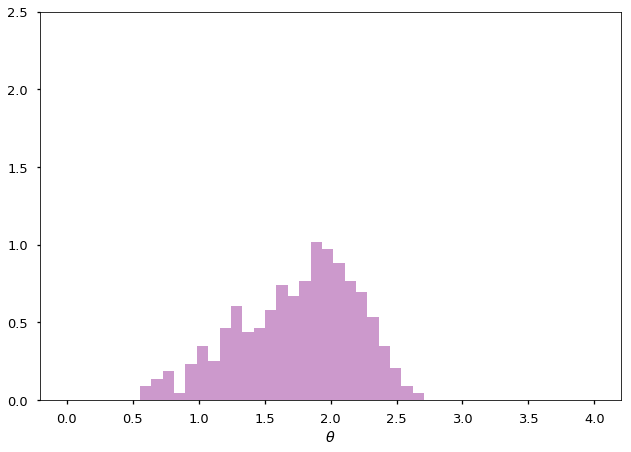

In [47]:
for name in ['phi', 'pi', 'theta']:
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(pd.Series([est[name] 
                                for est, cov in est_arr]).dropna(), ax=ax, color='purple', bins=25,
                     kde=False, norm_hist=True)
    diff = (bounds[name]['max'] - bounds[name]['min'])
    ax.set_xlim([bounds[name]['min'] - .05 * diff ,  bounds[name]['max'] + .05 * diff])

    ax.set_ylim([0, 10 / diff])
        
    ax.set_xlabel(f"$\{name}$")

    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".tmp.pdf", frameon=False, pad_inches=0,
                bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [48]:
omega

{'gamma': 0.013387603765924991,
 'beta': 3.9491764428157703,
 'psi': -3.229874444457632,
 'zeta': 0.828326903416641,
 'log_both': -5.930037761549001,
 'log_scale': -5.506163240212154,
 'logit_rho': 1.2650207500703528}

In [49]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [50]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [51]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [52]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

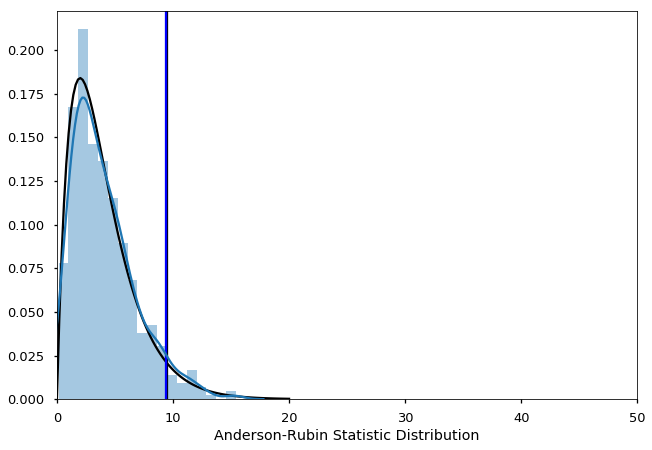

In [53]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 50)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')
    sns.distplot(ar_results, ax=ax)

In [54]:
np.mean(ar_results >= stats.chi2.ppf(df=4, q=.95))

0    0.046
dtype: float64

In [55]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=1000, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [57]:
returnval.mean()

qlr_stat               2.859527
robust_qlr_qauntile    8.877107
robust                 0.022000
standard               0.030000
dtype: float64

In [58]:
np.percentile(returnval.qlr_stat, 95)

7.002699112662159

In [59]:
true_params['phi']

-0.4

In [60]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [61]:
returnval.mean()

qlr_stat               2.859527
robust_qlr_qauntile    8.877107
robust                 0.022000
standard               0.030000
dtype: float64

In [62]:
returnval.query('robust_qlr_qauntile > 0').mean()

qlr_stat               2.859527
robust_qlr_qauntile    8.877107
robust                 0.022000
standard               0.030000
dtype: float64

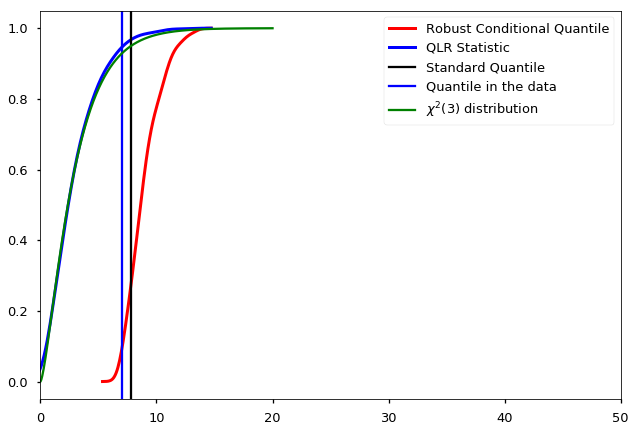

In [63]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)